In [123]:
import pandas as pd
import numpy as np

import os
import pickle
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer

from keras.layers import Embedding, Flatten, Dense, SimpleRNN
from keras.models import Sequential

from keras import preprocessing

import matplotlib.pyplot as plt 


from tensorflow.keras.callbacks import EarlyStopping

# Data Preprocessing
Import the IMBD data set, skipping the most common words

In [103]:
# References:
# https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/
# hhttps://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

def preprocess_review(filename):
    # open the review
    review = open(filename, 'r')
    text = review.read()
    review.close()
    
    # remove line break tags
    text = text.replace('<br />', ' ')

    # remove tokens that are not alphabetic
    tokens = text.split()

    # filter out stop words with nltk
    stop_words = set(stopwords.words('english'))
    tokens = [w.lower() for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w)>1]
    
    return ' '.join(tokens)


def preprocess_directory(directory):
    # Create the list of reviews
    text = []

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            src = os.getcwd() + '/' + directory + '/' + filename

            # Preprocess the review and append it to the list
            text.append(preprocess_review(src))

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/voldemort/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
imdb_train_neg = preprocess_directory(os.path.join('aclImdb/train/neg'))
pickle.dump(imdb_train_neg, open('imdb_train_neg.pkl', 'wb'))

In [106]:
imdb_train_pos = preprocess_directory(os.path.join('aclImdb/train/pos'))
pickle.dump(imdb_train_pos, open('imdb_train_pos.pkl', 'wb'))

imdb_train_neutral = preprocess_directory(os.path.join('aclImdb/train/unsup'))
pickle.dump(imdb_train_neutral, open('imdb_train_neutral.pkl', 'wb'))

imdb_test_pos = preprocess_directory(os.path.join('aclImdb/test/pos'))
pickle.dump(imdb_test_pos, open('imdb_test_pos.pkl', 'wb'))

imdb_test_neg = preprocess_directory(os.path.join('aclImdb/test/neg'))
pickle.dump(imdb_test_neg, open('imdb_test_neg.pkl', 'wb'))


In [2]:
imdb_train_pos = pickle.load(open('imdb_train_pos.pkl', 'rb'))
imdb_train_neg = pickle.load(open('imdb_train_neg.pkl', 'rb'))

imdb_test_pos = pickle.load(open('imdb_test_pos.pkl', 'rb'))
imdb_test_neg = pickle.load(open('imdb_test_neg.pkl', 'rb'))

In [3]:
train_labels_pos = [1] * len(imdb_train_pos)
train_labels_neg = [0] * len(imdb_train_pos)

train_data = imdb_train_pos + imdb_train_neg
train_labels = train_labels_pos + train_labels_neg

In [4]:
test_labels_pos = [1] * len(imdb_test_pos)
test_labels_neg = [0] * len(imdb_test_pos)

test_data = imdb_test_pos + imdb_test_neg
test_labels = test_labels_pos + test_labels_neg

In [5]:
train_df = pd.DataFrame({'Text': train_data, 'Sentiment': train_labels})
test_df = pd.DataFrame({'Text': test_data, 'Sentiment': test_labels})



In [6]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
train_data = np.asarray(train_df['Text'])
train_labels = np.asarray(train_df['Sentiment'])

test_data = np.asarray(test_df['Text'])
test_labels = np.asarray(test_df['Sentiment'])

## Keras Embeddings + MLP

In [126]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))


Found 88065 unique tokens


In [128]:
maxlen=20
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)


In [129]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.6540 - acc: 0.6576 - val_loss: 0.5770 - val_acc: 0.7424
Epoch 2/10
20000/20000 [==============================] - 1s 48us/step - loss: 0.4673 - acc: 0.8014 - val_loss: 0.4723 - val_acc: 0.7710
Epoch 3/10
20000/20000 [==============================] - 2s 89us/step - loss:

In [130]:
score = model.evaluate(x_test, test_labels, verbose=1)

25000/25000 [==============================] - 1s 48us/step


In [131]:
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

Test Loss: 0.47428444431304934 Test Accuracy: 0.792


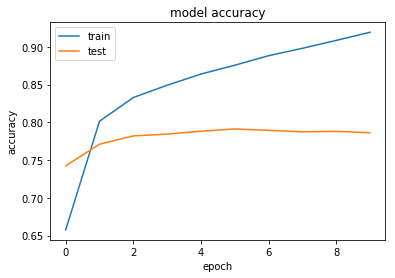

In [132]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

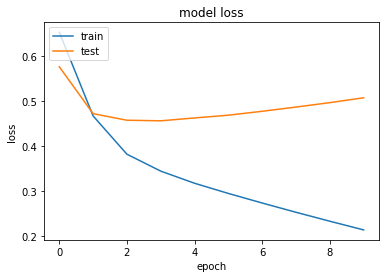

In [133]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Second MLP Attempt
Let's try increasing the length of the inputs and adding early stopping once the validation scores stop improving

In [134]:
maxlen=50
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 82us/step - loss: 0.5841 - acc: 0.7346 - val_loss: 0.4383 - val_acc: 0.8144
Epoch 2/50
20000/20000 [==============================] - 1s 47us/step - loss: 0.3360 - acc: 0.8642 - val_loss: 0.3645 - val_acc: 0.8374
Epoch 3/50
20000/20000 [==============================] - 1s 48us/step - loss: 

In [135]:
score = model.evaluate(x_test, test_labels, verbose=1)

25000/25000 [==============================] - 1s 48us/step


In [136]:
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

Test Loss: 0.33549573088645934 Test Accuracy: 0.85348


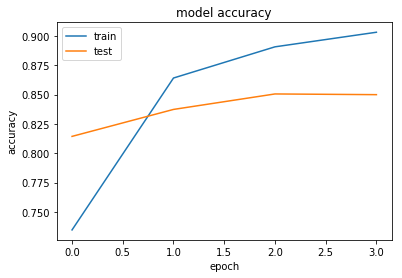

In [137]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

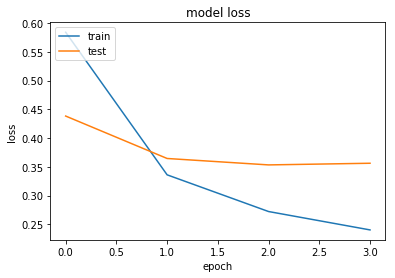

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Third MLP Attempt
That brought some improvement. Let's try increasing the length of the inputs again.

In [140]:
maxlen=100
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

model = Sequential()

model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 8)            80000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 97us/step - loss: 0.6233 - acc: 0.6762 - val_loss: 0.4433 - val_acc: 0.8318
Epoch 2/50
20000/20000 [==============================] - 2s 114us/step - loss: 0.3125 - acc: 0.8826 - val_loss: 0.3129 - val_acc: 0.8660
Epoch 3/50
20000/20000 [==============================] - 3s 126us/step - loss

In [141]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 1s 21us/step
Test Loss: 0.2862664505672455 Test Accuracy: 0.87932


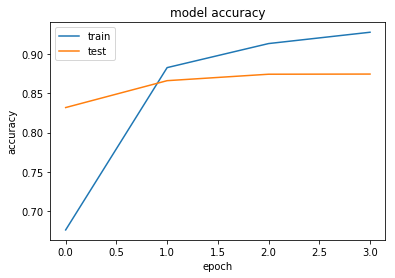

In [142]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

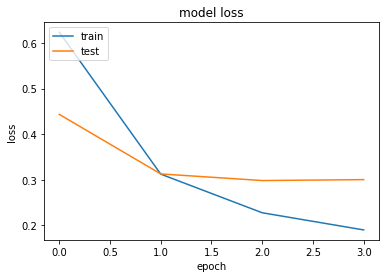

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR data

In [60]:
edgar_data = pd.read_json('merged_transcripts.json')

In [61]:
edgar_data.head()

,Sentiment,Text
0,Neutral,Could you catch us up on your latest thinking ...
1,Neutral,We continue to ramp up the activities for the ...
10,Neutral,"I think, we're …"
100,Neutral,"Greg, I wonder if I just get a couple of clari..."
1000,Negative,"First, we successfully increased our wallet sh..."


In [62]:
edgar_data.shape

(1649, 2)

In [65]:
edgar_data['Sentiment'].value_counts(dropna=False)

neutral       529
positive      504
Neutral       289
Positive      121
negative      116
Negative       37
 positive      17
postive        12
 neutral        9
NaN             6
Neural          3
Negetive        2
 negative       2
 neutral        1
neutra;         1
Name: Sentiment, dtype: int64

In [66]:
edgar_data.replace('Neutral', 'neutral', inplace=True)
edgar_data.replace(' neutral', 'neutral', inplace=True)
edgar_data.replace(' neutral ', 'neutral', inplace=True)
edgar_data.replace('neutra;', 'neutral', inplace=True)
edgar_data.replace('Neural', 'neutral', inplace=True)
edgar_data.replace('None', 'neutral', inplace=True)
edgar_data.replace('Negative', 'negative', inplace=True)
edgar_data.replace('Negetive', 'negative', inplace=True)
edgar_data.replace(' negative', 'negative', inplace=True)
edgar_data.replace('Positive', 'positive', inplace=True)
edgar_data.replace(' positive', 'positive', inplace=True)
edgar_data.replace(' positive ', 'positive', inplace=True)
edgar_data.replace('postive', 'positive', inplace=True)
edgar_data.fillna('neutral', inplace=True)

In [67]:
edgar_data['Sentiment'].value_counts()

neutral     838
positive    654
negative    157
Name: Sentiment, dtype: int64

In [69]:
edgar_data.to_csv('cleaned_merged_data.csv', index=False)

In [72]:
edgar_test = edgar_data[edgar_data['Sentiment'] != 'neutral']

In [73]:
edgar_test.head()

,Sentiment,Text
1000,negative,"First, we successfully increased our wallet sh..."
1001,positive,"Second, we remained focused on leveraging our ..."
1002,positive,"Lastly, we remained focused on continued inves..."
1003,positive,"Moving to Page 8. In Equities, as it relates t..."
1004,positive,"For 2018, Equities produced net revenues of $7..."


In [74]:
edgar_test.shape

(811, 2)

In [77]:
edgar_test['Sentiment'] = edgar_test['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
edgar_test['Sentiment'].value_counts()

1    654
0    157
Name: Sentiment, dtype: int64

In [79]:
edgar_test_labels = np.asarray(edgar_test['Sentiment'])

In [153]:
edgar_x_test = edgar_test['Text'].tolist()

edgar_x_sequences = tokenizer.texts_to_sequences(edgar_x_test)

In [154]:
edgar_x_sequences = preprocessing.sequence.pad_sequences(edgar_x_sequences, maxlen=maxlen)

In [155]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 70us/step


In [157]:
scores = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)

811/811 [==============================] - 0s 41us/step


In [159]:
print('Test Loss:', scores[0], 'Test Accuracy:', scores[1])

Test Loss: 0.8774671805919172 Test Accuracy: 0.5277435266574714


In [166]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))

In [167]:
cfm

array([[ 99,  58],
       [325, 329]])

# Bag of Words

In [11]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data)
x_train = tokenizer.texts_to_matrix(train_data, mode='freq')
x_test = tokenizer.texts_to_matrix(test_data, mode='freq')

In [12]:
n_words = x_train.shape[1]

model = Sequential()

model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                500050    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 500,101
Trainable params: 500,101
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 7s 343us/step - loss: 0.5956 - acc: 0.8113 - val_loss: 0.4774 - val_acc: 0.8468
Epoch 2/50
20000/20000 [==============================] - 6s 294us/step - loss: 0.3845 - acc: 0.8726 - val_loss: 0.3366 - val_acc: 0.8740
Epoch 3/50
20000/20000 [==============================] - 6s 293us/step - loss: 0.2902 - acc: 0.8925 - val_loss: 0.2908 - val_acc: 0.8842
Epoch 4/50
20000/20000 [==============================] - 6s 295us/st

In [13]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 4s 143us/step
Test Loss: 0.2813756000137329 Test Accuracy: 0.88668


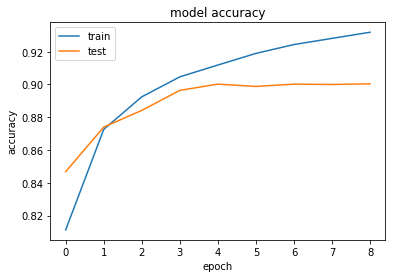

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

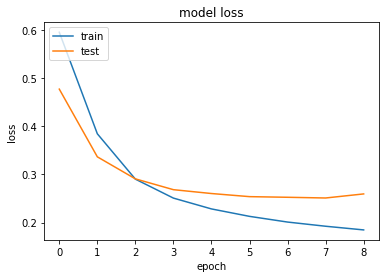

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
edgar_data = pd.read_csv('cleaned_merged_data.csv')
edgar_test = edgar_data[edgar_data['Sentiment'] != 'neutral']
edgar_test['Sentiment'] = edgar_test['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
edgar_x_test_bow = tokenizer.texts_to_matrix(edgar_test['Text'].tolist(), mode='freq')
edgar_test_labels = np.asarray(edgar_test['Sentiment'])

In [25]:
score = model.evaluate(edgar_x_test_bow, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 98us/step
Test Loss: 0.7389699452902327 Test Accuracy: 0.6818742296404668


In [54]:
predictions = model.predict(edgar_x_test_bow, verbose=1)

811/811 [==============================] - 0s 49us/step


In [55]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[ 57, 100],
       [158, 496]])

# Bag of Words + TF-IDF

In [8]:
# Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
X_train_counts.shape

(25000, 74848)

In [9]:
count_vect.vocabulary_.get(u'algorithm')

2611

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(25000, 74848)

In [48]:
X_test_counts = count_vect.transform(test_data)
X_test_tf = tf_transformer.transform(X_test_counts)

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tf.toarray(), train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
X_test_tf = X_test_tf.toarray()
predictions0 = gnb.predict(X_test_tf[:1000])
predictions1 = gnb.predict(X_test_tf[1000:5000])
predictions2 = gnb.predict(X_test_tf[5000:10000])
predictions3 = gnb.predict(X_test_tf[10000:15000])
predictions4 = gnb.predict(X_test_tf[15000:20000])
predictions5 = gnb.predict(X_test_tf[20000:])
predictions = np.concatenate((predictions0, predictions1, predictions2, predictions3, predictions4, predictions5))

In [50]:
accuracy_score(test_labels, predictions)

0.572

In [51]:
cfm = confusion_matrix(test_labels, predictions)
cfm

array([[8716, 3784],
       [6916, 5584]])

In [45]:
edgar_X_test_counts = count_vect.transform(edgar_test['Text'].tolist())
edgar_X_test_tf = tf_transformer.transform(edgar_X_test_counts)

In [52]:
predictions = gnb.predict(edgar_X_test_tf.toarray())
cfm = confusion_matrix(edgar_test_labels, predictions)
cfm

array([[ 93,  64],
       [388, 266]])

In [53]:
accuracy_score(edgar_test_labels, predictions)

0.44266337854500615

# GLOVE Embeddings

In [110]:
maxlen = 100  # We will cut reviews after 100 words
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 88065 unique tokens


In [111]:
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

In [112]:
glove_dir = 'glove6B'

embeddings_index = {}
f = open(os.path.join(os.getcwd(), glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [113]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [114]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [116]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, test_labels),
                    callbacks=[EarlyStopping(patience=1)])
model.save_weights('pre_trained_glove_model.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 7s 270us/step - loss: 0.5680 - acc: 0.7094 - val_loss: 0.6585 - val_acc: 0.6674
Epoch 2/10
25000/25000 [==============================] - 7s 291us/step - loss: 0.4405 - acc: 0.7969 - val_loss: 0.5169 - val_acc: 0.7499
Epoch 3/10
25000/25000 [==============================] - 7s 292us/step - loss: 0.3641 - acc: 0.8358 - val_loss: 0.5856 - val_acc: 0.7346


In [117]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 0s 18us/step
Test Loss: 0.5855996667861938 Test Accuracy: 0.73456


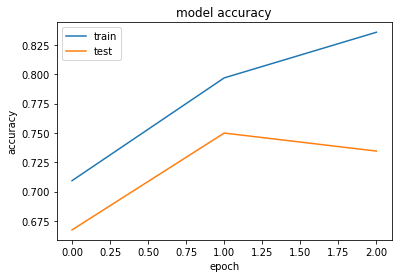

In [118]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

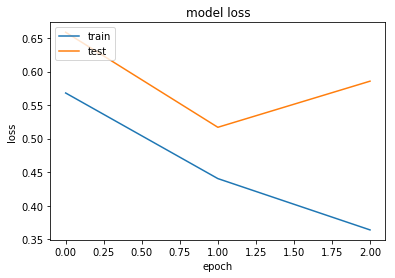

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
edgar_x_test = edgar_test['Text'].tolist()
edgar_x_sequences = tokenizer.texts_to_sequences(edgar_x_test)
edgar_x_sequences = preprocessing.sequence.pad_sequences(edgar_x_sequences, maxlen=maxlen)

In [120]:
score = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 43us/step
Test Loss: 0.9182979278587972 Test Accuracy: 0.5659679409608006


In [121]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 119us/step


In [122]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[114,  43],
       [309, 345]])

## GloVe 2nd Attempt - Tuning
In the previous attempt the GloVe embedding weights were fixed. This time we will try tuning them.

In [94]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, test_labels),
                    callbacks = [EarlyStopping(patience=1)])

model.save_weights('tuned_glove_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 6s 242us/step - loss: 0.4867 - acc: 0.7612 - val_loss: 0.3881 - val_acc: 0.8232
Epoch 2/10
25000/25000 [==============================] - 8s 304us/step - lo

In [95]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 2s 63us/step
Test Loss: 0.4022915400314331 Test Accuracy: 0.84924


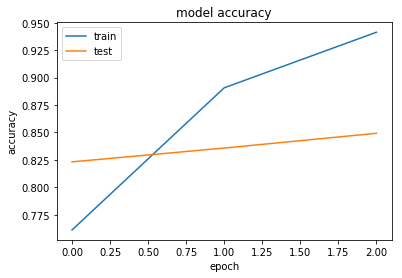

In [96]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

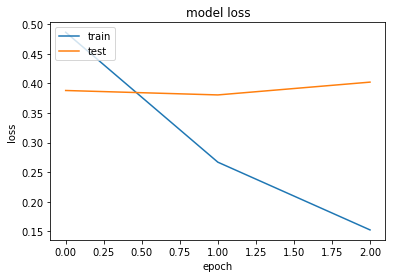

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
score = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 42us/step
Test Loss: 0.7718967105251646 Test Accuracy: 0.6769420467087431


In [101]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 92us/step


In [103]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[ 66,  91],
       [171, 483]])

# RNN